<a href="https://colab.research.google.com/github/ver0z/Segmentacao-Clientes-Perfil/blob/main/Data_Science_Projeto_Segmenta%C3%A7%C3%A3o_de_Clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Utilizando o poder de fogo do Python e o algoritmo de clusterização K-means para fazer a segmentação de clientes baseado no perfil de cada.  
* Clusterização de clientes

![Clientes por características](https://cdn-cemfc.nitrocdn.com/prVXKFGqEhkqWRitMvLtbacbvotgrvJH/assets/static/optimized/rev-763eada/wp-content/uploads/2020/04/Customer-segmentation-and-campaigns.png)


Uma forma de uma empresa entender a quem que ela atende, é pela segmentação do seu público. A razão para se ter domínio dessas informações, vem do fato de que isso possibilita que as empresas atendam seu público de forma mais individual e direcionada aos indivíduos que consomem o produto dela, baseado no comportamento, perfil e capacidade financeira.

Para auxiliar nessa tarefa existem algumas técnicas de machine learning (apredizado de máquina) que no seu cerne tem bastante estatística. Aqui utilizarei o popular K-means, algoritmo de aprendizagem não supervisionada.

Esse algoritmo tem a capacidade de pegar um cliente e dizer a qual grupo ele pertence, baseado apenas nos dados brutos do cliente, por isso é *não supervisionado*, ou seja, não precisa que alguém diga qual o grupo, ele mesmo descobre.

O K-means tem como objetivo separar todos clientes em grupos, bem definidos, de forma que cada um não seja igual o outro, ou seja, eles não podem se sobrepor; Isso ocorre, porque cada grupo tem características que os tornam distinguíveis dos outros.

![Clientes por características](https://miro.medium.com/max/1400/1*Q2edegNErVecPADsdm2AAw.png)

Para demonstrar como essa técnica é de grande utilidade foi utilizado o dataset **Mall Customer Segmentation Data** disponível no [link](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python?resource=download)

---

Para início é necessário que se tenha as bibliotecas pandas, numpy, matplotlib, seaborn, scikit-learn, kneed, elas possuem uma grande quantidade das ferramentas que são utilizadas para data science. Como estou usando o colab, a maioria das bibliotecas já estão instaladas, caso não esteja, utilize o `!pip install nomedabiblioteca`

# **Importando as bibliotecas e os dados a serem analisados**



In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# reading the data frame

df = pd.read_csv('Mall_Customers.csv')

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


De início percebemos que existem cinco variáveis nesse dataset, o CustomerID é um identificador único de cada cliente, é utilizado em base de dados relacionais para identificar exclusivamente cada linha em seus dados. Contudo, para a análise de formação de grupos essa informação é irrelevante, então podemos tirá-la do conjunto.

Outra informação é sobre o gênero de cada cliente que pode ser 'male' ou 'female' sendo necessária a conversão de string para um formato númerico.

Por fim, antes de ser utilizado o K-means de fato temos que normalizar as variáveis que não possuem informação categóricas, ou seja, as outras três que não tínhamos mencionado ainda e podem assumir qualquer valor. A padronização desses valores será feita por uma distribuição normal que terá média 0 e desvio-padrão 1. 

O resultado disso é mostrado na tabela a seguir 

In [ ]:
coluna_nome = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
caracteristicas = df[coluna_nome]
escala = StandardScaler().fit(caracteristicas.values)
caracteristicas = escala.transform(caracteristicas.values)
dados_escalados = pd.DataFrame(caracteristicas, columns=coluna_nome)
dados_escalados.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


Após a transformação as variavéis agora estão centradas ao redor de zero.

---
**One hot encoding** é procedimento de transformar uma variável categórica em variável númerica. É esse procedimento que será feito para a váriavel de gênero.
Masculino ou feminino agora será representado por 0's ou 1's.

In [ ]:
genero = df['Gender']
novo_df = dados_escalados.join(genero)

novo_df = pd.get_dummies(novo_df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

novo_df = novo_df.drop(['Gender_Male'],axis=1) # Retidado, pois é o complementar de Gender_Female, logo apenas uma coluna é suficiente

novo_df.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


#**Criação do modelo K-means**

Com os dados formatados, já podemos utilizar o K-means e ver como os dados se comportam, para uma primeira análise vamos mostrar graficamente pelo método Elbow qual será o melhor valor de clusterização **k** esse valor permitirá ver de forma otimizada em quantos grupos todos os clientes podem ser distribuídos. Para mais detalhes sobre esse método [veja](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) 



Text(0, 0.5, 'Inércia')

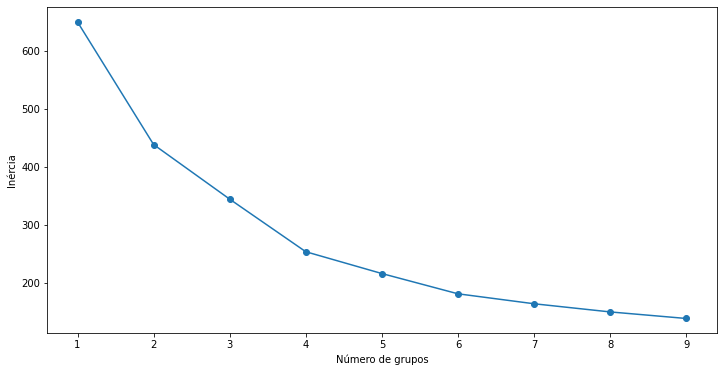

In [ ]:
SSE = []

for grupos in range(1,10):
    kmeans = KMeans(n_clusters = grupos, init='k-means++')
    kmeans.fit(novo_df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Número de grupos')
plt.ylabel('Inércia')

Com base no gráfico pode-se dizer que o melhor valor é 4, tendo em vista que após ele os outros valores passam a tender o para um valor e estabilizar.

#**Silhouette Score**

![texto do link](https://miro.medium.com/max/1400/1*cUcY9jSBHFMqCmX-fp8BvQ.jpeg)
Outra forma de avaliar a qualidade dos nossos grupos, os valores de saída irão variar entre -1 e 1. A equação dessa métrica é descrita da seguinte forma:

$Silhouette Score = \frac{(b-a)}{max(a,b)}$

a= distância média intra-cluster, ou seja, a distância média entre cada ponto dentro de um cluster.

b = distância média entre clusters, ou seja, a distância média entre todos os clusters.

* Resultado igual a 1 significa que os grupos estão bem separados uns dos outros e claramente distinguidos

* Saída 0 significa que os grupos são indiferentes, ou podemos dizer que a distância entre os grupos não é significativa.

* E saída -1 significa que os grupos são atribuídos de maneira errada.



In [ ]:
# Utilizando o valor de k = 4 que encontramos

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(novo_df)

# Now, print the silhouette score of this model

print(silhouette_score(novo_df, kmeans.labels_, metric='euclidean'))

0.35027020434653977


Com o valor de **0.35** próximo de ser indiferente, é possível melhorar para que os grupos se tornem mais distinguidos. Pois como veremos devem existir mistura de elementos em grupos muito próximos.

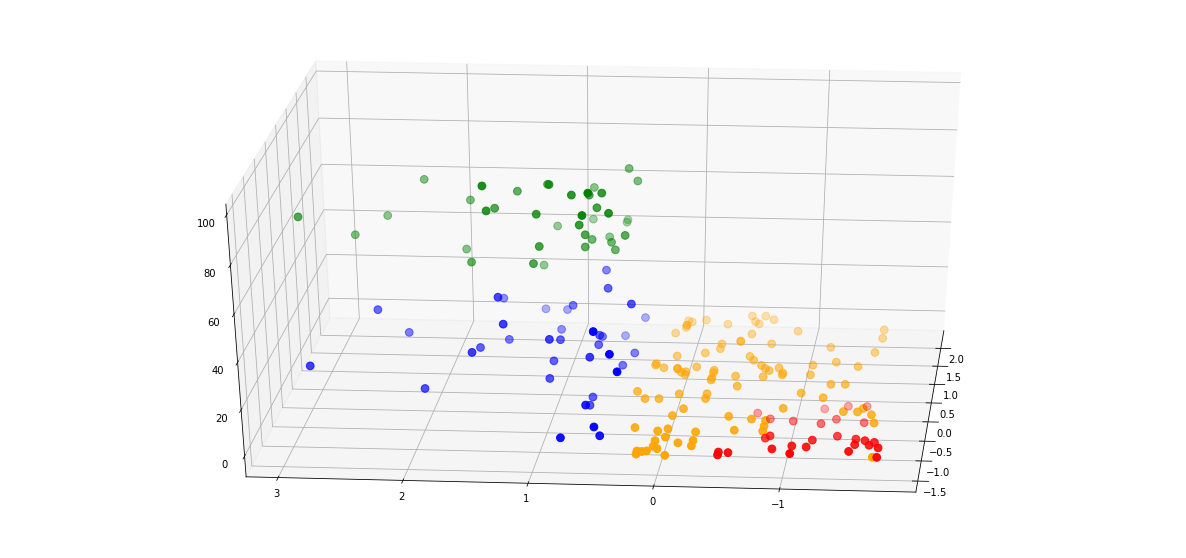

In [ ]:
grupos = kmeans.fit_predict(df.iloc[:,2:])
novo_df['label'] = grupos
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(novo_df.Age[novo_df.label == 0], novo_df["Annual Income (k$)"][novo_df.label == 0], df["Spending Score (1-100)"][novo_df.label == 0], c='blue', s=60)

ax.scatter(novo_df.Age[novo_df.label == 1], novo_df["Annual Income (k$)"][novo_df.label == 1], novo_df["Spending Score (1-100)"][novo_df.label == 1], c='red', s=60)
ax.scatter(novo_df.Age[novo_df.label == 2], novo_df["Annual Income (k$)"][novo_df.label == 2], df["Spending Score (1-100)"][novo_df.label == 2], c='green', s=60)
ax.scatter(novo_df.Age[novo_df.label == 3], novo_df["Annual Income (k$)"][novo_df.label == 3], novo_df["Spending Score (1-100)"][novo_df.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

De fato alguns grupos ainda não estão bem definidos e alguns pontos azuis estão dentro de outros grupos, assim como o verde e vermelho.
---



#**Principal Component Analysis (PCA)**
---

Uma outra forma de melhorar o modelo é utilizando a técnica de componente principal PCA, que seleciona apenas algumas das variáveis com maior variância e diminui o dataset no total essa diminuição tem perda de informação, mas é uma opção para quando se tem muitas variáveis e algumas não são tão relevantes.
Podemos mostrar quais são as variáveis mais relevantes para esse dataset da seguinte maneira:

66.52220418463503


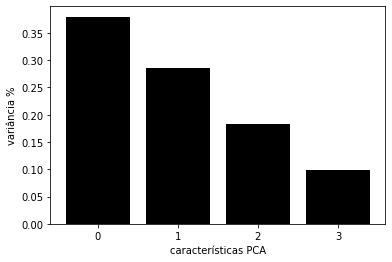

In [ ]:
pca = PCA(n_components=4)
principais_componentes = pca.fit_transform(novo_df)

caracteristicas = range(pca.n_components_)
plt.bar(caracteristicas, pca.explained_variance_ratio_, color='black')
plt.xlabel('características PCA')
plt.ylabel('variância %')
plt.xticks(caracteristicas)
print((pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100)

PCA_components = pd.DataFrame(principais_componentes)

Dado os valores acima, podemos perceber que as variáveis de PCA 0 e 1 correspondem por 66.5% da variância dos dados. Utilizaremos essas duas variáveis para verificar como se sai o modelo novamente.

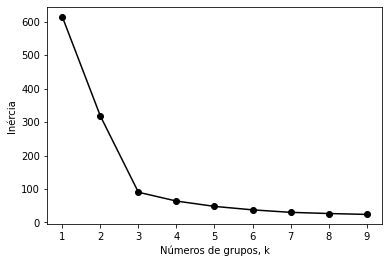

In [ ]:
ks = range(1, 10)
inercias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inercias.append(model.inertia_)
# Quando o gráfico dobra significa que no valor da dobra é o valor a se tomar
plt.plot(ks, inercias, '-o', color='black')
plt.xlabel('Números de grupos, k')
plt.ylabel('Inércia')
plt.xticks(ks)
plt.show()

O valor de k agora é 3, como observado não houve muita diferença visual para a anterior, mas veremos isso melhor a seguir.

In [ ]:
model = KMeans(n_clusters=3)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

0.6545437022112282


O valor agora está mais próximo de 1 significando que, sim, melhorou, os grupos estão um pouco mais definidos.

Vamos verificar visualmente essa diferença

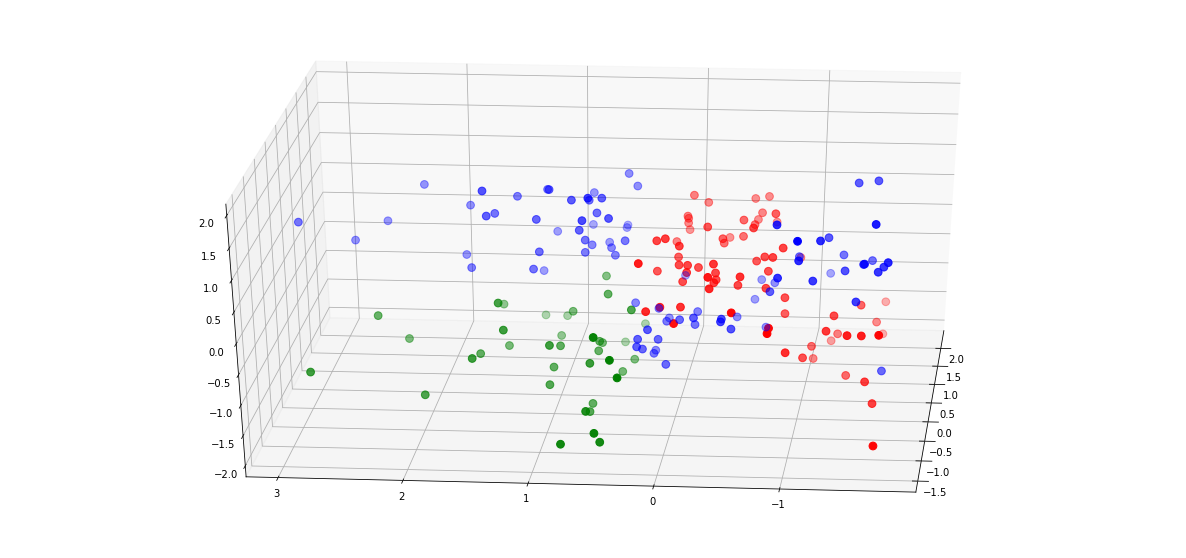

In [ ]:
model = KMeans(n_clusters=3)

grupos = model.fit_predict(PCA_components.iloc[:,:2])
novo_df["label"] = grupos
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(novo_df.Age[novo_df.label == 0], novo_df["Annual Income (k$)"][novo_df.label == 0], novo_df["Spending Score (1-100)"][novo_df.label == 0], c='blue', s=60)
ax.scatter(novo_df.Age[novo_df.label == 1], novo_df["Annual Income (k$)"][novo_df.label == 1], novo_df["Spending Score (1-100)"][novo_df.label == 1], c='red', s=60)
ax.scatter(novo_df.Age[novo_df.label == 2], novo_df["Annual Income (k$)"][novo_df.label == 2], novo_df["Spending Score (1-100)"][novo_df.label == 2], c='green', s=60)

ax.scatter(novo_df.Age[novo_df.label == 3], novo_df["Annual Income (k$)"][novo_df.label == 3], novo_df["Spending Score (1-100)"][novo_df.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

In [ ]:
sns.scatterplot(novo_df.label == 1, Z [1], matiz = rótulo)

Apesar de o valor da silhoete ser maior, visualmente essa diferença não se mostrou muito aparente. 

Entretanto iremos usar o segundo modelo, o de PCA.

#**Análise dos grupos criados**

---

Realizando os primeiros passos de leitura dos dados e dropando a coluna de CustumerID

Após isso iremos associar cada grupo com os dados

In [ ]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['Grupo'] = pred
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Grupo
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,1
3,Female,23,16,77,0
4,Female,31,17,40,1


Agora cada linha corresponde a um grupo específico 

No intento de realizar comparações, primeiro temos que saber a média de cada variável ao longo de todos os grupos.

In [ ]:
avg_df = df.groupby(['Grupo'], as_index=False).mean()
avg_df

,Grupo,Age,Annual Income (k$),Spending Score (1-100)
0,0,28.068966,61.321839,72.367816
1,1,50.573333,46.280000,40.480000
2,2,40.394737,87.000000,18.631579


De forma facilitar o entendimento dos números, podemos dispor eles em forma de colunas 

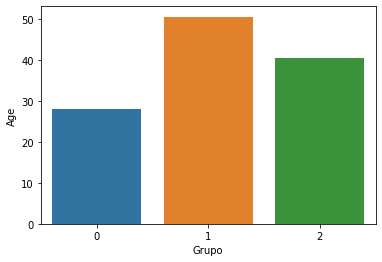

In [ ]:
sns.barplot(x='Grupo',y='Age',data=avg_df)

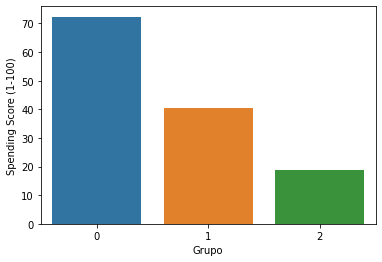

In [ ]:
sns.barplot(x='Grupo',y='Spending Score (1-100)',data=avg_df)

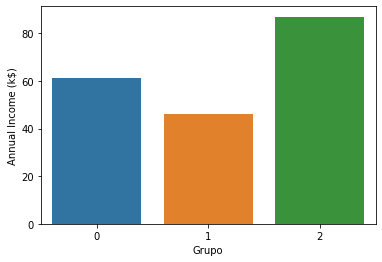

In [ ]:
sns.barplot(x='Grupo',y='Annual Income (k$)',data=avg_df)

#Grupos por idade

In [ ]:
df2 = pd.DataFrame(df.groupby(['Grupo','Gender'])['Gender'].count())
df2.head()

Gender
Grupo Gender        
0     Female      48
      Male        39
1     Female      46
      Male        29
2     Female      18

---

# **Principais características de cada grupo**

---

* Grupo 0

> É um grupo de risco onde as pessoas recebem menos do que ganham na média, a maioria é composta por mulheres e estão entorno de 48 anos. Em caso de crédito é necessário cuidado ao conceder crédito muito alto e como gastam muito e no sentido de manter esse consumo elevado, mas com moderação é indicado oferecer produtos com promoções, descontos.

* Grupo 1

> Neste grupo consta a maioria sendo mulheres. Ganham quase na mesma proporção que gastam, com a média de idade de 50 anos é provável que tenham família e por tal motivo gastem essa quantia, devem estar se aproximando da aposentadoria, e um plano de previdência seria uma boa propaganda para este grupo, quem sabe até um plano de saúde.

* Grupo 3

> O grupo com maior capacidade financeira na média e menos gasta, este grupo pode ser o das pessoas que apenas gastam quando necessário ou o produto está em custo-benefício, este tipo de cliente sabe onde usar o dinheiro e não vai sair gastando à toa. Como é um grupo composto apenas por mulheres pode ser viável oferecer cuidados de saúde, pets, plano de investimento, descontos em compras de roupas online.



